In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords

#sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Word2vec
import gensim

# Utility
import re
import numpy as np
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [3]:
# DATASET
DATASET_COLUMNS = ["user", "time", "text", "label"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.9

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 12
BATCH_SIZE = 1024

# SENTIMENT
NO_EMOTION = "NO_EMOTION"
EMOTION = "EMOTION"

### Read Dataset

In [4]:
df = pd.read_csv('D:/NLP/Dataset/1_krl-stage1.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [5]:
print("Dataset size:", len(df))

Dataset size: 78270


In [6]:
df.head(5)

,user,time,text,label
0,antoe_21,1/1/2017 7:00,maaf mau tanya kenapaa krl nambo depok berangk...,0
1,antoe_21,1/1/2017 7:04,brarti ada berangkat jam brapa,0
2,antoe_21,1/1/2017 7:06,untuk di tiada hanya hari berangkat jam 645 tsb,0
3,tabitaindah,1/1/2017 7:10,maaf tidak tahu nomor pokok tadi jakarta kota ...,0
4,tabitaindah,1/1/2017 7:12,tp tadi jelang berangkat sudah tugas usir2 pin...,0


In [7]:
decode_map = {0: "NO_EMOTION", 1: "EMOTION"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.label = df.label.apply(lambda x: decode_sentiment(x))

CPU times: total: 15.6 ms
Wall time: 23.9 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

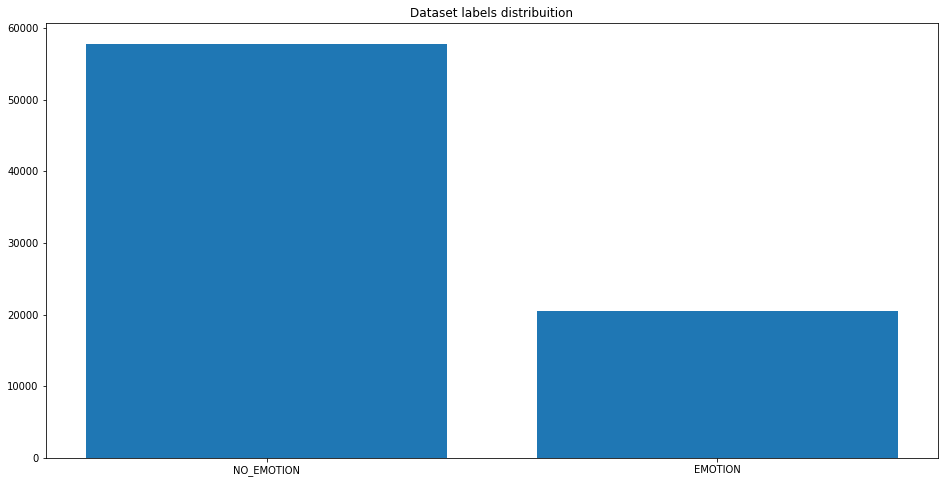

In [9]:
label_cnt = Counter(df.label)

plt.figure(figsize=(16,8))
plt.bar(label_cnt.keys(), label_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [10]:
stop_words = stopwords.words("indonesian")
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 7.28 s
Wall time: 7.44 s


### Split train and test

In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=0)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 70443
TEST size: 7827


### Word2Vec 

In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: total: 219 ms
Wall time: 240 ms


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2022-07-19 18:53:08,762 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2022-07-19T18:53:08.762620', 'gensim': '4.2.0', 'python': '3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}


In [16]:
w2v_model.build_vocab(documents)

2022-07-19 18:53:08,782 : INFO : collecting all words and their counts
2022-07-19 18:53:08,784 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-07-19 18:53:08,809 : INFO : PROGRESS: at sentence #10000, processed 72010 words, keeping 8337 word types
2022-07-19 18:53:08,836 : INFO : PROGRESS: at sentence #20000, processed 143231 words, keeping 12730 word types
2022-07-19 18:53:08,867 : INFO : PROGRESS: at sentence #30000, processed 215323 words, keeping 16308 word types
2022-07-19 18:53:08,893 : INFO : PROGRESS: at sentence #40000, processed 286772 words, keeping 19281 word types
2022-07-19 18:53:08,918 : INFO : PROGRESS: at sentence #50000, processed 358385 words, keeping 22103 word types
2022-07-19 18:53:08,946 : INFO : PROGRESS: at sentence #60000, processed 429982 words, keeping 24628 word types
2022-07-19 18:53:08,969 : INFO : PROGRESS: at sentence #70000, processed 501284 words, keeping 26958 word types
2022-07-19 18:53:08,972 : INFO : collected 27060

In [17]:
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 3095


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-07-19 18:53:09,136 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 3095 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2022-07-19T18:53:09.136653', 'gensim': '4.2.0', 'python': '3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'train'}
2022-07-19 18:53:09,638 : INFO : EPOCH 0: training on 504446 raw words (328851 effective words) took 0.5s, 715234 effective words/s
2022-07-19 18:53:10,145 : INFO : EPOCH 1: training on 504446 raw words (328798 effective words) took 0.5s, 729479 effective words/s
2022-07-19 18:53:10,653 : INFO : EPOCH 2: training on 504446 raw words (328967 effective words) took 0.5s, 668478 effective words/s
2022-07-19 18:53:11,108 : INFO : EPOCH 3: training on 504446 raw words (328805 effective words) took 0.4s, 748978 effective words/s
2022-07-19 18:53:11,613 : INFO : EPOCH 4: training on

CPU times: total: 48.2 s
Wall time: 14.9 s


(10527825, 16142272)

In [19]:
w2v_model.wv.most_similar("bagus")

[('jelek', 0.5374749898910522),
 ('kualitas', 0.5137009024620056),
 ('sangat2', 0.512752890586853),
 ('kesini', 0.48037058115005493),
 ('jepang', 0.4695627987384796),
 ('muas', 0.4635760486125946),
 ('infrastruktur', 0.4266968369483948),
 ('salut', 0.42545127868652344),
 ('tingkat', 0.42089325189590454),
 ('buruk', 0.40702101588249207)]

### Tokenize Text

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 27061
CPU times: total: 1.11 s
Wall time: 1.11 s


In [21]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 1.45 s
Wall time: 1.46 s


### Label Encoder 

In [22]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (70443, 1)
y_test (7827, 1)


In [23]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (70443, 300)
y_train (70443, 1)

x_test (7827, 300)
y_test (7827, 1)


In [24]:
y_train[:10]

array([[1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1]])

### Embedding layer

In [25]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(27061, 300)


In [26]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [27]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(256, recurrent_dropout=0.3)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          8118300   
                                                                 
 conv1d (Conv1D)             (None, 300, 128)          153728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 75, 64)           0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 512)              6

### Compile model

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [29]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Train

In [30]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/12
62/62 [==============================] - 1023s 16s/step - loss: 0.3964 - accuracy: 0.8105 - val_loss: 0.3274 - val_accuracy: 0.8476 - lr: 0.0010
Epoch 2/12
62/62 [==============================] - 906s 15s/step - loss: 0.3065 - accuracy: 0.8582 - val_loss: 0.3120 - val_accuracy: 0.8555 - lr: 0.0010
Epoch 3/12
62/62 [==============================] - 934s 15s/step - loss: 0.2828 - accuracy: 0.8697 - val_loss: 0.3146 - val_accuracy: 0.8549 - lr: 0.0010
Epoch 4/12
62/62 [==============================] - 986s 16s/step - loss: 0.2621 - accuracy: 0.8807 - val_loss: 0.3218 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 5/12
62/62 [==============================] - 981s 16s/step - loss: 0.2318 - accuracy: 0.8979 - val_loss: 0.3380 - val_accuracy: 0.8514 - lr: 0.0010
Epoch 6/12
62/62 [==============================] - 1017s 16s/step - loss: 0.2082 - accuracy: 0.9105 - val_loss: 0.3765 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 7/12
62/62 [==============================] - 1038s 17s/step -

### Evaluate

In [31]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

8/8 [==============================] - 35s 4s/step - loss: 0.4225 - accuracy: 0.8434

ACCURACY: 0.8433626890182495
LOSS: 0.4225270748138428
CPU times: total: 1min 51s
Wall time: 34.8 s


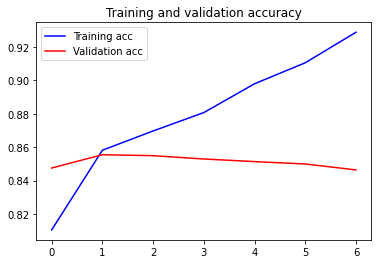

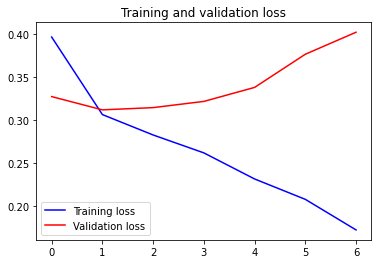

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Confusion Matrix

In [33]:
import seaborn as sns

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

245/245 [==============================] - 55s 215ms/step


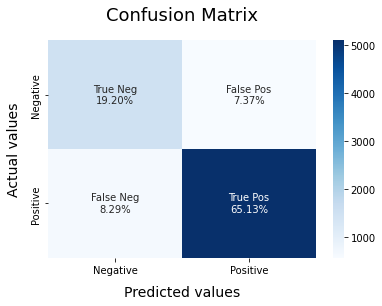

In [34]:
# Predicting on the Test dataset.
y_pred = model.predict(x_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

### Classification Report

In [35]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.6984    0.7226    0.7103      2080
           1     0.8983    0.8871    0.8927      5747

    accuracy                         0.8434      7827
   macro avg     0.7984    0.8048    0.8015      7827
weighted avg     0.8452    0.8434    0.8442      7827



### Accuracy Score

In [36]:
accuracy_score(y_test, y_pred)

0.8433627187939184

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)